In [52]:
!pip install -U scikit-fuzzy
!pip install deap


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from deap import base, creator, tools, algorithms
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

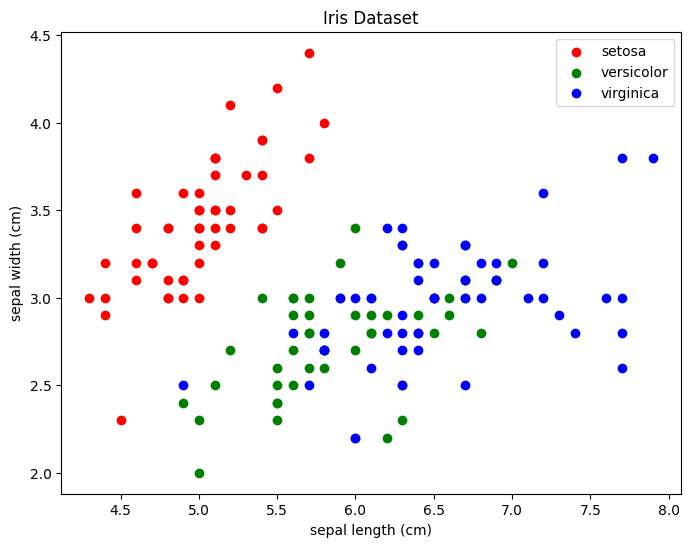

In [54]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
plot_iris_data(X, y)  # Visualize the Iris dataset

In [55]:
#again reshape y axis for training/testing
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

In [56]:
# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

In [57]:
#(ANN) model
def create_ann_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [58]:
# Fuzzy Logic model
def create_fuzzy_logic_model():
    # Define input and output variables
    sepal_length_universe = np.linspace(4, 8, 100)
    sepal_width_universe = np.linspace(2, 4.5, 100)
    petal_length_universe = np.linspace(1, 7, 100)
    petal_width_universe = np.linspace(0, 2.5, 100)

    #fuzzy membership functions
    sepal_length_fuzzy = fuzz.gaussmf(sepal_length_universe, mean=5.5, sigma=1)
    sepal_width_fuzzy = fuzz.gaussmf(sepal_width_universe, mean=3.5, sigma=0.5)
    petal_length_fuzzy = fuzz.gaussmf(petal_length_universe, mean=4, sigma=1)
    petal_width_fuzzy = fuzz.gaussmf(petal_width_universe, mean=1.2, sigma=0.3)

    # Fuzzy rules
    rule1 = np.fmin(sepal_length_fuzzy, sepal_width_fuzzy)
    rule2 = np.fmin(petal_length_fuzzy, petal_width_fuzzy)
    rule3 = np.fmin(rule1, rule2)  # Combine rules AND operator

    # Aggregation
    aggregated = np.fmax(rule1, rule2, rule3)

    # Defuzzification (weighted average based on model)
    class_weights = np.argmax(y_train, axis=1) + 1
    predicted_class = np.average(np.arange(3), weights=aggregated, axis=0)
    return predicted_class

In [59]:
# Visualization fuzzy membership functions
def plot_fuzzy_memberships():
    sepal_length_universe = np.linspace(4, 8, 100)
    sepal_length_fuzzy = fuzz.gaussmf(sepal_length_universe, mean=5.5, sigma=1)
    plot_fuzzy_memberships(sepal_length_universe, sepal_length_fuzzy)
    plt.figure(figsize=(8, 6))
    plt.plot(sepal_length_universe, sepal_length_fuzzy, label='Sepal Length')
    plt.xlabel('Sepal Length')
    plt.ylabel('Membership Degree')
    plt.title('Fuzzy Membership Functions')
    plt.legend()

In [61]:
# Genetic Algorithm
def evaluate(individual):
    # Evaluate fitness
    ann_weights = []
    ann_biases = []
    start = 0
    for layer in ann_model.layers:
        weights_shape = layer.get_weights()[0].shape
        biases_shape = layer.get_weights()[1].shape
        num_weights = np.prod(weights_shape)
        num_biases = np.prod(biases_shape)
        ann_weights.append(individual[start:start + num_weights].reshape(weights_shape))
        ann_biases.append(individual[start + num_weights:start + num_weights + num_biases].reshape(biases_shape))
        start += num_weights + num_biases
    ann_model.set_weights(ann_weights + ann_biases)
    y_pred_ann = ann_model.predict(X_train)
    y_pred_